In [55]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../src')

from pathlib import Path
import pandas as pd
from zipfile import ZipFile
from visualizations import plot_geopandas, plot_correlation, plot_pie, plot_dist
from matplotlib import pyplot as plt
from pns_dict import PNS_DICT
from visualizations import plot_bar
import seaborn as sns
import numpy as np

from constants import BRAZIL_IDH

PNS_DATA = Path('../data/processed/PNS_2019/all.zip').resolve()
zip_pns = ZipFile(PNS_DATA)
df = pd.read_csv(zip_pns.open(zip_pns.namelist()[0]), sep=",", low_memory=False)

PATH_GEN_DATA = Path('generated_data/pns_data_description').resolve()

def save_fig(fig_i, name):
    fig_i.savefig(PATH_GEN_DATA / '00_pns_{}.png'.format(name), bbox_inches='tight')
    fig_i.savefig(PATH_GEN_DATA / '00_pns_{}.pdf'.format(name), bbox_inches='tight')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
print("O dataset PNS possui {} linhas e {} colunas (features).".format(*df.shape))

O dataset PNS possui 90846 linhas e 380 colunas (features).


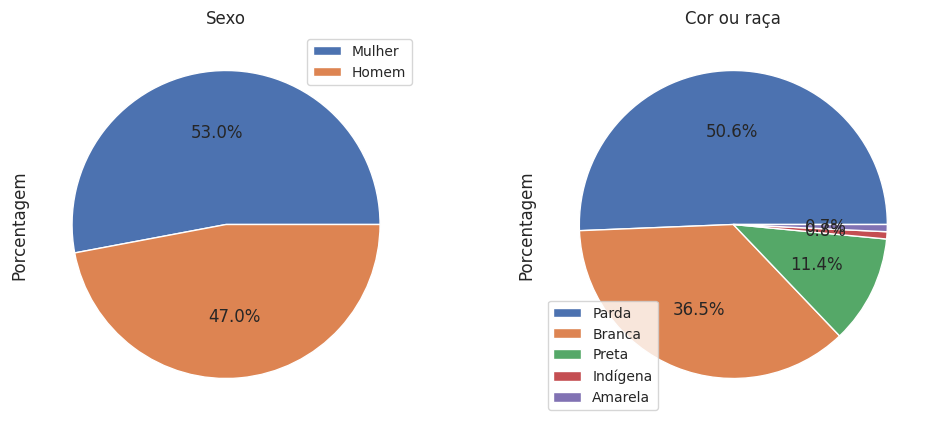

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_pie(df, 'sexo', 'Sexo', desc_dict=PNS_DICT.get_pv_dict('sexo'), ax=axes[0])
plot_pie(df, 'cor', 'Cor ou raça', desc_dict=PNS_DICT.get_pv_dict('cor'), ax=axes[1])
save_fig(fig, 'sexo_cor')
plt.show()

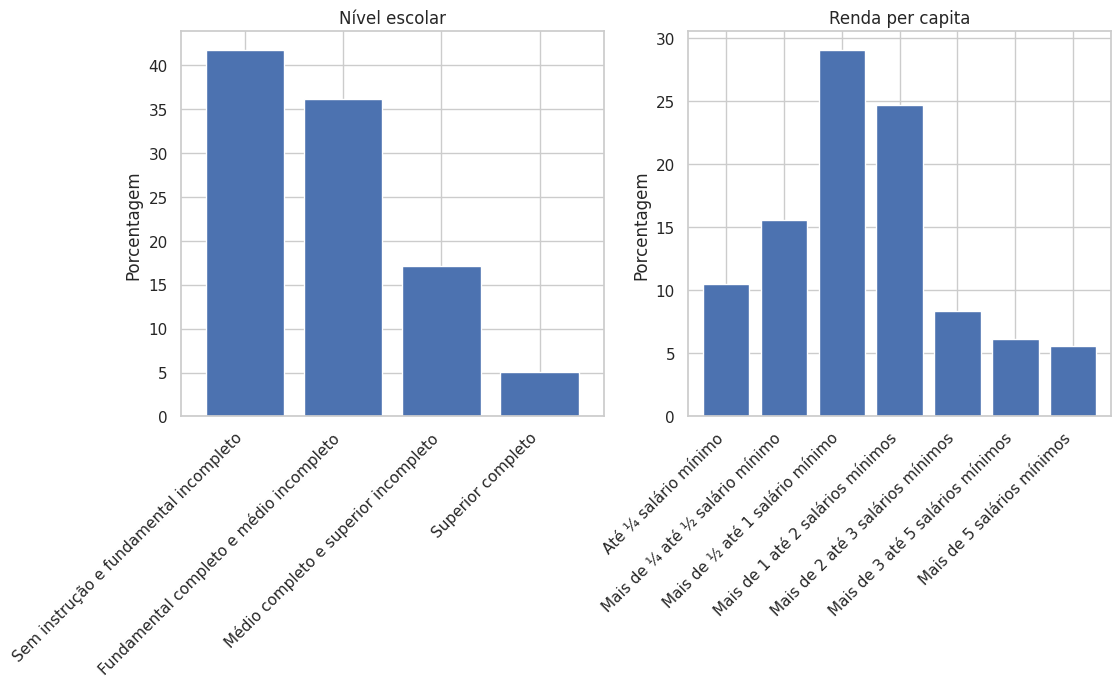

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_bar(df, 'escolaridade_agregada', 'Nível escolar', desc_dict=PNS_DICT.get_pv_dict('escolaridade_agregada'), ax=axes[0])
plot_bar(df, 'renda_pc', 'Renda per capita', desc_dict=PNS_DICT.get_pv_dict('renda_pc'), ax=axes[1])
save_fig(fig, 'escolaridade_renda')
plt.show()

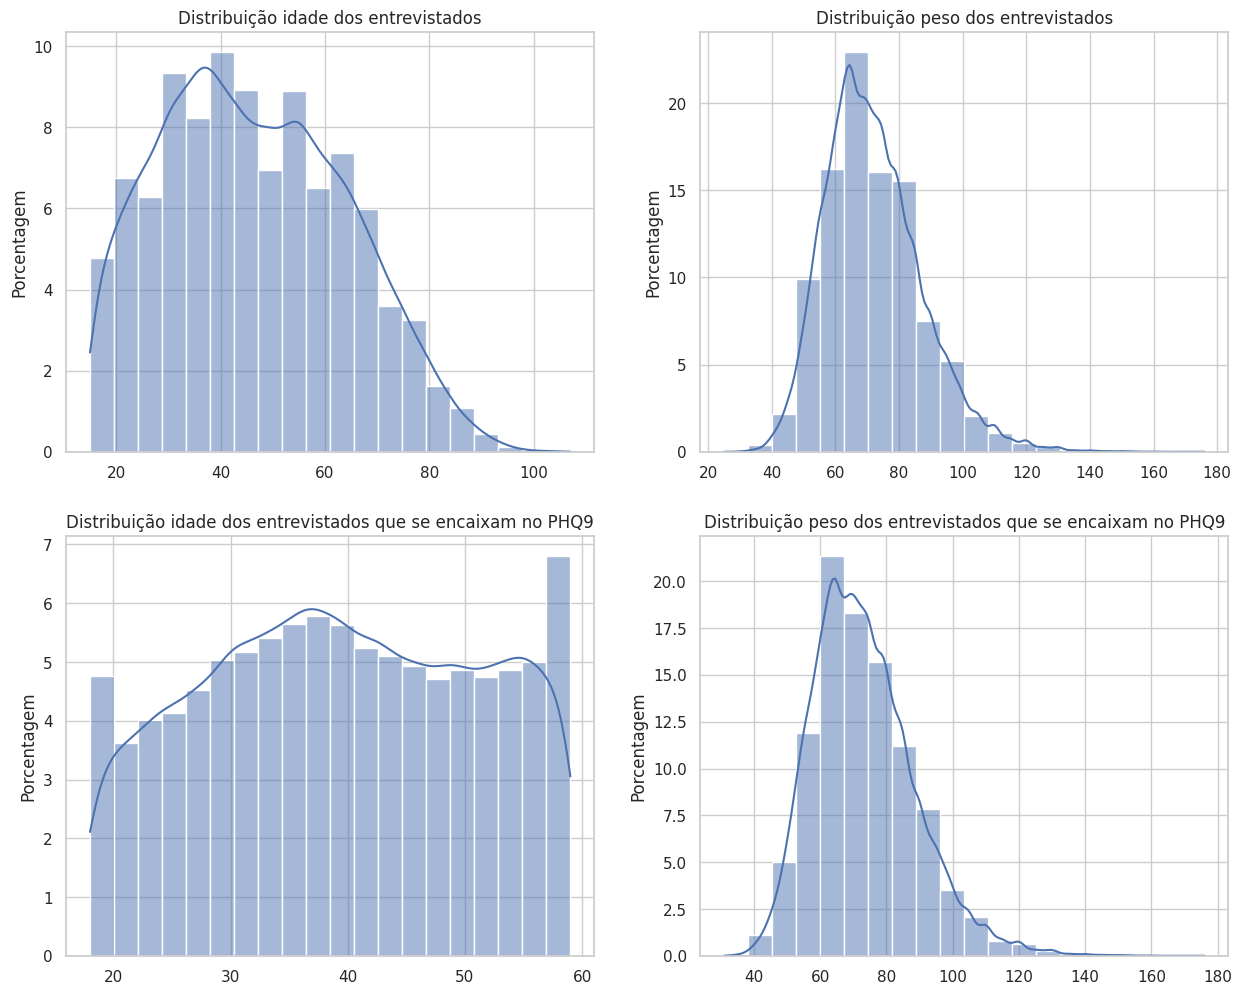

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
plot_dist(df['idade'], 'Distribuição idade dos entrevistados', ax=axes[0, 0])
plot_dist(df['peso'], 'Distribuição peso dos entrevistados', ax=axes[0, 1])

selected = df.dropna(subset=['phq9_total'])
plot_dist(selected['idade'], 'Distribuição idade dos entrevistados que se encaixam no PHQ9', ax=axes[1, 0])
plot_dist(selected['peso'], 'Distribuição peso dos entrevistados que se encaixam no PHQ9', ax=axes[1, 1])
save_fig(fig, 'idade_peso')
plt.show()

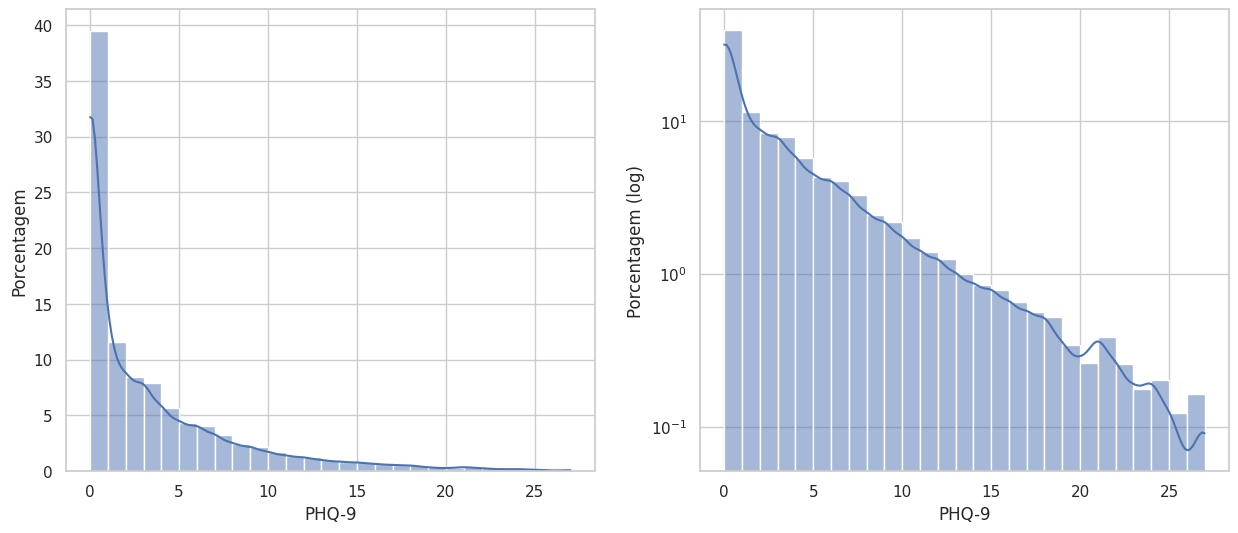

In [8]:
selected = df.dropna(subset=['phq9_total'])
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.histplot(selected['phq9_total'], bins=27, kde=True, ax=ax[0], stat='percent')
ax[0].set_ylabel('Porcentagem')
ax[0].set_xlabel('PHQ-9')

sns.histplot(selected['phq9_total'], bins=27, kde=True, ax=ax[1], stat='percent')
ax[1].set_yscale('log')
ax[1].set_ylabel('Porcentagem (log)')
ax[1].set_xlabel('PHQ-9')


save_fig(fig, 'phq9_total_dist')
plt.show()

# Estado de depressão e suas relações

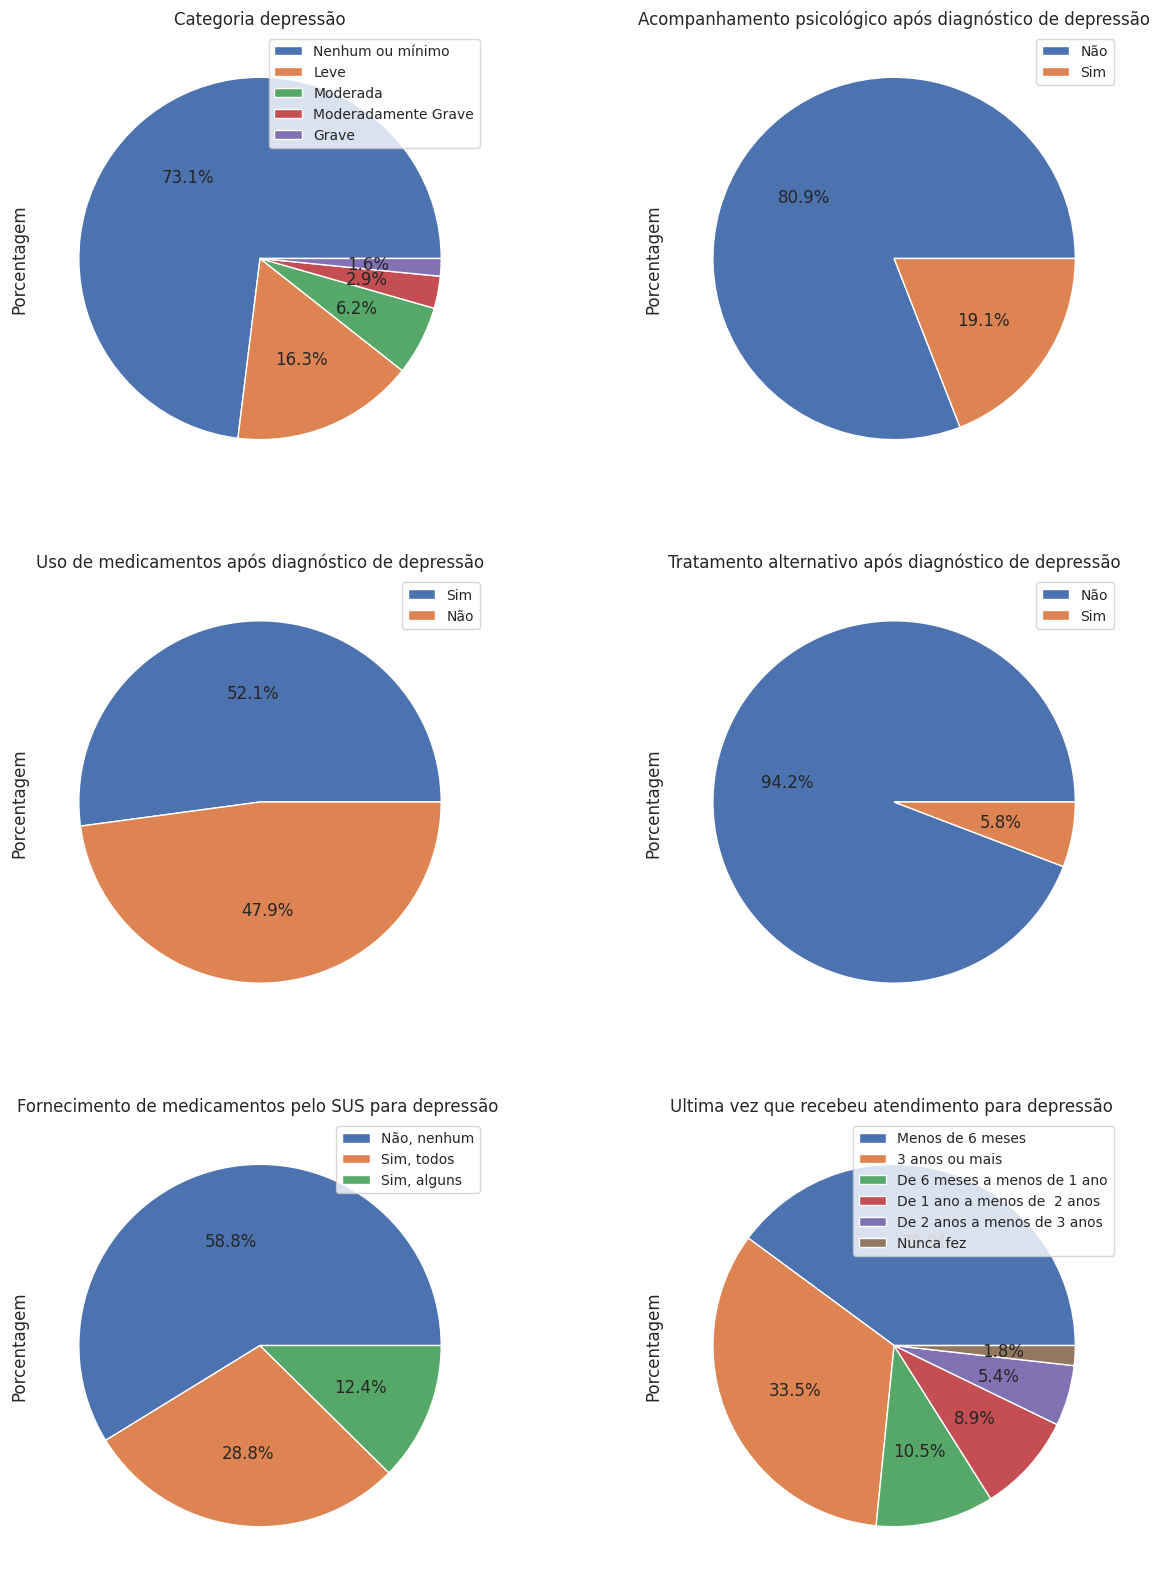

In [9]:
fig, axes = plt.subplots(3, 2, figsize=(15, 20))
plot_pie(df, 'depression_severity',  'Categoria depressão', desc_dict=PNS_DICT.get_pv_dict('depression_severity'), ax=axes[0][0])
plot_pie(df, 'Q09605', 'Acompanhamento psicológico após diagnóstico de depressão', desc_dict=PNS_DICT.get_pv_dict('Q09605'), ax=axes[0][1])
plot_pie(df, 'Q09606', 'Uso de medicamentos após diagnóstico de depressão', desc_dict=PNS_DICT.get_pv_dict('Q09606'), ax=axes[1][0])
plot_pie(df, 'Q09607', 'Tratamento alternativo após diagnóstico de depressão', desc_dict=PNS_DICT.get_pv_dict('Q09607'), ax=axes[1][1])
plot_pie(df, 'Q098', 'Fornecimento de medicamentos pelo SUS para depressão ', desc_dict=PNS_DICT.get_pv_dict('Q098'), ax=axes[2][0])
plot_pie(df, 'Q10101', 'Ultima vez que recebeu atendimento para depressão ', desc_dict=PNS_DICT.get_pv_dict('Q10101'), ax=axes[2][1])
save_fig(fig, 'depression_stats')
plt.show()

# Distribuição depressão estados Brasil

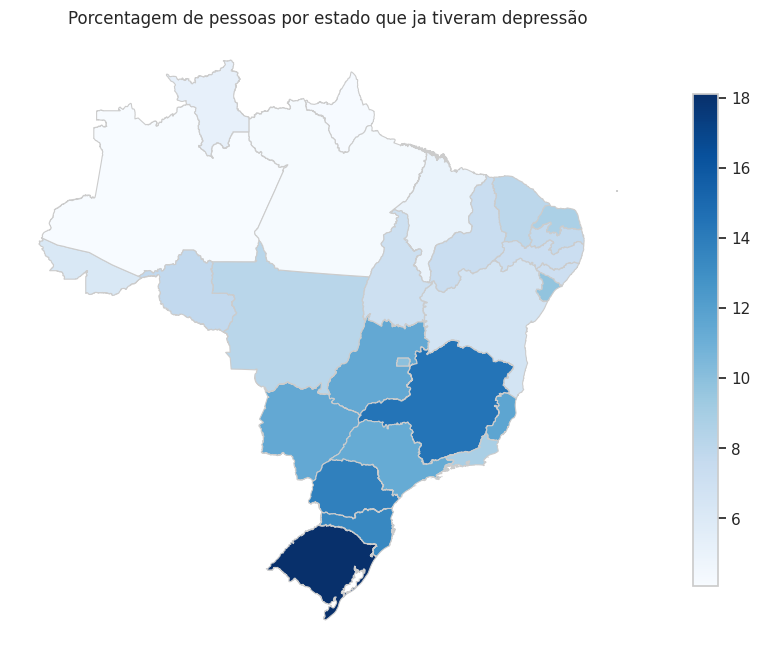

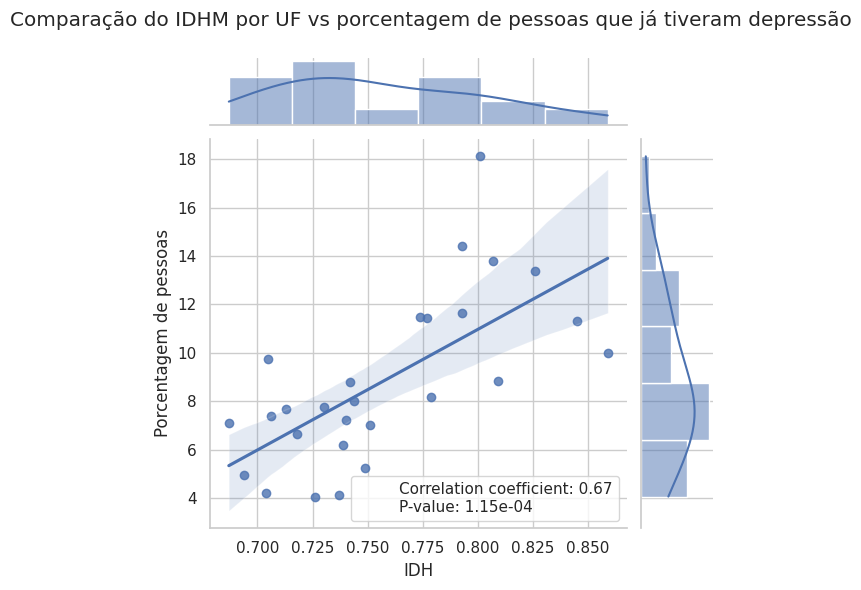

In [10]:
selected = df[['uf']][df['Q092'].isin([1])].value_counts() * 100 / df[['uf']].value_counts()
selected.name = 'values'
selected = selected.reset_index()
fig = plot_geopandas(selected, title="Porcentagem de pessoas por estado que ja tiveram depressão", uf_key='uf')
save_fig(fig, 'brazil_depression')

selected2 = BRAZIL_IDH.merge(selected, left_on='codigo_ibg', right_on='uf')

fig = plot_correlation(selected2, x='IDHM', y='values',
                       title='Comparação do IDHM por UF vs porcentagem de pessoas que já tiveram depressão',
                       xlabel='IDH', ylabel='Porcentagem de pessoas')

save_fig(fig, 'depression_idh_correlation')

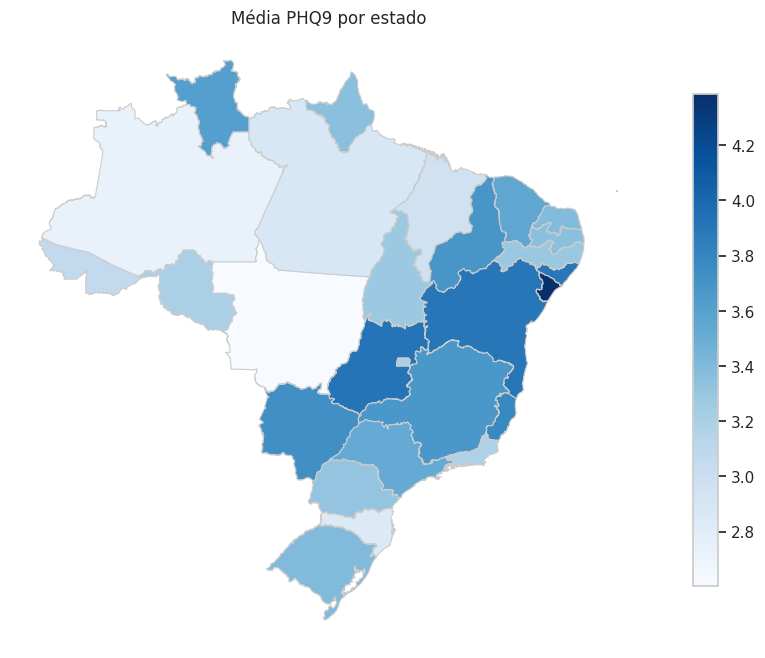

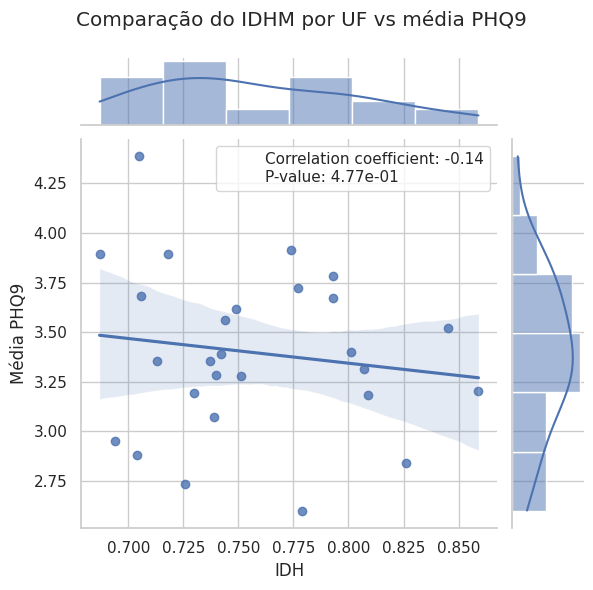

In [11]:
selected = df[['phq9_total', 'uf']].groupby('uf').agg('mean')
selected = selected.rename(columns={'phq9_total': 'values'})
selected = selected.reset_index()
fig = plot_geopandas(selected, title="Média PHQ9 por estado", uf_key='uf')
save_fig(fig, 'brazil_phq9')
plt.show()

selected2 = BRAZIL_IDH.merge(selected, left_on='codigo_ibg', right_on='uf')

fig = plot_correlation(selected2, x='IDHM', y='values',
                       title='Comparação do IDHM por UF vs média PHQ9',
                       xlabel='IDH', ylabel='Média PHQ9')

save_fig(fig, 'phq9_idh_correlation')

# Testes de modelos

In [56]:
df['depression'] = np.where(df['phq9_total'].isna(), np.nan, np.where(df['phq9_total'] >= 10, 1, 0))

In [57]:
df['depression'].value_counts()

depression
0.0    58451
1.0     6949
Name: count, dtype: int64

In [58]:
# Alimentos in natura ou minimamente processado
innatura = ['P00601','P00602', 'P00603', 'P00604', 'P00605', 'P00607', 'P00608', 'P00609', 'P00610', 'P00611', 'P00612', 'P00613']
df_innatura = df[innatura]
df_innatura['qst_innatura'] = (df_innatura == 1.0).sum(axis=1)
# Alimentos ultraprocessados
ultraprocessados = ['P00614', 'P00615', 'P00616', 'P00617', 'P00618', 'P00619', 'P00620', 'P00621', 'P00622', 'P00623']
df_upf = df[ultraprocessados]
df_upf['qst_upf'] = (df_upf == 1.0).sum(axis=1)

/tmp/ipykernel_307/2955397734.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_innatura['qst_innatura'] = (df_innatura == 1.0).sum(axis=1)
/tmp/ipykernel_307/2955397734.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_upf['qst_upf'] = (df_upf == 1.0).sum(axis=1)


In [59]:
df['per_innatura'] = df_innatura['qst_innatura'] / (df_innatura['qst_innatura'] + df_upf['qst_upf']) * 100
df['per_upf'] = df_upf['qst_upf'] / (df_innatura['qst_innatura'] + df_upf['qst_upf']) * 100

In [60]:
df['qst_upf'] = df_upf['qst_upf']

In [61]:
def classify_upf(row):
    value = row['qst_upf']

    if  0 <= value < 2:
        return 1
    elif value < 4:
        return 2
    elif value < 6:
        return 3
    elif value < 8:
        return 4
    elif value <= 10:
        return 5

    return np.nan # questionario não respondido ou idade não compativel

df['upf_severity'] = df.apply(classify_upf, axis=1)

In [62]:
df['upf_severity'].isnull().sum()

0

Calculando IMC

In [63]:
def count_imc(row):
    height = row['altura']
    weight = row['peso']

    imc = weight/np.square(height/100)   # Peso está em kg e altura em cm, no calculo do imc é kg/m^2
    return imc

df['imc'] = df.apply(count_imc, axis=1)

    

In [64]:
def classify_imc(row):
    value = row['imc']

    if  0 <= value < 18.5:
        return 1  # Baixo peso
    elif value < 24.9:
        return 2 # Eutrofia/peso adequado
    elif value < 29.9:
        return 3   # Sobrepeso
    elif value >= 30:
        return 4  # Obesidade

    return np.nan # questionario não respondido ou idade não compativel

df['class_imc'] = df.apply(classify_imc, axis=1)

In [65]:
df_activity = pd.DataFrame()
df_activity['minutes_per_week'] = df['P03702'] * df['P035']

vigorous_activities = [3.0, 4.0, 5.0, 6.0, 12.0, 13.0, 15.0]
moderated_activities = [1.0, 2.0, 7.0, 8.0, 9.0, 10.0, 11.0, 14.0, 16.0, 17.0]
df_activity['time_vigorous'] = df_activity['minutes_per_week'].loc[df['P036'].isin(vigorous_activities)]
df_activity['time_moderated'] = df_activity['minutes_per_week'].loc[df['P036'].isin(moderated_activities)]

df_activity['activity_class'] = 0
df_activity.loc[df_activity['minutes_per_week'].isna(), 'activity_class'] = np.nan
df_activity.loc[(df_activity['time_vigorous'] >= 75) | (df_activity['time_moderated'] >= 150), 'activity_class'] = 1

df['activity_class'] = df_activity['activity_class']

In [66]:
df['tabagismo'] = np.where(df['P050'].isin([1.0, 2.0]), 1, np.where(df['P050'] == 3.0, 0, np.nan))

In [67]:
df['cons_alcool'] = np.where(df['P02801'] >= 1, 1, 0)

df['cons_alcool'] = np.where(df['P02801'].isna(), np.nan, df['cons_alcool'])

In [68]:
df = df[df['P005'] != 1.0] #Retirando as grávidas da análise

In [37]:
print('Faltantes em Q092 - pergunta do diagnóstico de depressão: ', df['Q092'].isna().sum(), 'Perc:',  round(df['Q092'].isna().sum()/len(df['Q092'])*100, 3))
print('Faltantes em PHQ9_total - classificação de grau de depressão: ', df['phq9_total'].isna().sum(), 'Perc:',  round(df['phq9_total'].isna().sum()/len(df['phq9_total'])*100, 3))
print('Faltantes em UPF_severity - classificação de consumo de ultraprocessados: ', df['upf_severity'].isna().sum(), 'Perc:',  round(df['upf_severity'].isna().sum()/len(df['upf_severity'])*100, 3))
print('Faltantes em activity_class - classificação de atividade física: ', df['activity_class'].isna().sum(), 'Perc:',  round(df['activity_class'].isna().sum()/len(df['activity_class'])*100, 3))
print('Faltantes em tabagist - classificação de tabagismo: ', df['tabagismo'].isna().sum(), 'Perc:',  round(df['tabagismo'].isna().sum()/len(df['tabagismo'])*100, 3))
print('Faltantes em cons_alcool - clasificação do consumo de álcool: ', df['cons_alcool'].isna().sum(), 'Perc:',  round(df['cons_alcool'].isna().sum()/len(df['cons_alcool'])*100, 3))

Faltantes em Q092 - pergunta do diagnóstico de depressão:  476 Perc: 0.528
Faltantes em PHQ9_total - classificação de grau de depressão:  25411 Perc: 28.211
Faltantes em UPF_severity - classificação de consumo de ultraprocessados:  566 Perc: 0.628
Faltantes em activity_class - classificação de atividade física:  55225 Perc: 61.31
Faltantes em tabagist - classificação de tabagismo:  476 Perc: 0.528
Faltantes em cons_alcool - clasificação do consumo de álcool:  65995 Perc: 73.267


In [38]:
new_df = df[df['phq9_total'] >= 5].copy()
print('Faltantes em Q092 - pergunta do diagnóstico de depressão: ', new_df['Q092'].isna().sum(), 'Perc:',  round(new_df['Q092'].isna().sum()/len(new_df['Q092'])*100, 3))
print('Faltantes em UPF_severity - classificação de consumo de ultraprocessados: ', new_df['upf_severity'].isna().sum(), 'Perc:',  round(new_df['upf_severity'].isna().sum()/len(new_df['upf_severity'])*100, 3))
print('Faltantes em activity_class - classificação de atividade física: ', new_df['activity_class'].isna().sum(), 'Perc:',  round(new_df['activity_class'].isna().sum()/len(new_df['activity_class'])*100, 3))
print('Faltantes em tabagist - classificação de tabagismo: ', new_df['tabagismo'].isna().sum(), 'Perc:',  round(new_df['tabagismo'].isna().sum()/len(new_df['tabagismo'])*100, 3))
print('Faltantes em cons_alcool - clasificação do consumo de álcool: ', new_df['cons_alcool'].isna().sum(), 'Perc:',  round(new_df['cons_alcool'].isna().sum()/len(new_df['cons_alcool'])*100, 3))


Faltantes em Q092 - pergunta do diagnóstico de depressão:  0 Perc: 0.0
Faltantes em UPF_severity - classificação de consumo de ultraprocessados:  10 Perc: 0.058
Faltantes em activity_class - classificação de atividade física:  10909 Perc: 62.891
Faltantes em tabagist - classificação de tabagismo:  0 Perc: 0.0
Faltantes em cons_alcool - clasificação do consumo de álcool:  12201 Perc: 70.339


In [39]:
print('Faltantes em Q120 - pergunta do diagnóstico de cancer: ', df['Q120'].isna().sum(), 'Perc:',  round(df['Q120'].isna().sum()/len(df['Q120'])*100, 3))
print('Faltantes em Q00201 - diagnotisco pressão alta: ', df['Q00201'].isna().sum(), 'Perc:',  round(df['Q00201'].isna().sum()/len(df['Q00201'])*100, 3))
print('Faltantes em Q03001 - diagnostico diabetes: ', df['Q03001'].isna().sum(), 'Perc:',  round(df['Q03001'].isna().sum()/len(df['Q03001'])*100, 3))
print('Faltantes em Q06306 - diagnostico cardiovascular : ', df['Q06306'].isna().sum(), 'Perc:',  round(df['Q06306'].isna().sum()/len(df['Q06306'])*100, 3))
print('Faltantes em Q060 - diagnostico colesterol alto: ', df['Q060'].isna().sum(), 'Perc:',  round(df['Q060'].isna().sum()/len(df['Q060'])*100, 3))
print('Faltantes em Q068 - diagnostico de AVC: ', df['Q068'].isna().sum(), 'Perc:',  round(df['Q068'].isna().sum()/len(df['Q068'])*100, 3))
print('Faltantes em Q079 - diagnostico de artrite: ', df['Q079'].isna().sum(), 'Perc:',  round(df['Q079'].isna().sum()/len(df['Q079'])*100, 3))
print('Faltantes em class_imc - classificação de imc: ', df['class_imc'].isna().sum(), 'Perc:',  round(df['class_imc'].isna().sum()/len(df['class_imc'])*100, 3))

Faltantes em Q120 - pergunta do diagnóstico de cancer:  476 Perc: 0.528
Faltantes em Q00201 - diagnotisco pressão alta:  2566 Perc: 2.849
Faltantes em Q03001 - diagnostico diabetes:  7170 Perc: 7.96
Faltantes em Q06306 - diagnostico cardiovascular :  476 Perc: 0.528
Faltantes em Q060 - diagnostico colesterol alto:  8332 Perc: 9.25
Faltantes em Q068 - diagnostico de AVC:  476 Perc: 0.528
Faltantes em Q079 - diagnostico de artrite:  476 Perc: 0.528
Faltantes em class_imc - classificação de imc:  913 Perc: 1.014


In [16]:
print('Faltantes em Q120 - pergunta do diagnóstico de cancer: ', new_df['Q120'].isna().sum(), 'Perc:',  round(new_df['Q120'].isna().sum()/len(new_df['Q120'])*100, 3))
print('Faltantes em Q00201 - diagnotisco pressão alta: ', new_df['Q00201'].isna().sum(), 'Perc:',  round(new_df['Q00201'].isna().sum()/len(new_df['Q00201'])*100, 3))
print('Faltantes em Q03001 - diagnostico diabetes: ', new_df['Q03001'].isna().sum(), 'Perc:',  round(new_df['Q03001'].isna().sum()/len(new_df['Q03001'])*100, 3))
print('Faltantes em Q06306 - diagnostico cardiovascular : ', new_df['Q06306'].isna().sum(), 'Perc:',  round(new_df['Q06306'].isna().sum()/len(new_df['Q06306'])*100, 3))
print('Faltantes em Q060 - diagnostico colesterol alto: ', new_df['Q060'].isna().sum(), 'Perc:',  round(new_df['Q060'].isna().sum()/len(new_df['Q060'])*100, 3))
print('Faltantes em Q068 - diagnostico de AVC: ', new_df['Q068'].isna().sum(), 'Perc:',  round(new_df['Q068'].isna().sum()/len(new_df['Q068'])*100, 3))
print('Faltantes em Q079 - diagnostico de artrite: ', new_df['Q079'].isna().sum(), 'Perc:',  round(new_df['Q079'].isna().sum()/len(new_df['Q079'])*100, 3))
print('Faltantes em class_imc - classificação de imc: ', new_df['class_imc'].isna().sum(), 'Perc:',  round(new_df['class_imc'].isna().sum()/len(new_df['class_imc'])*100, 3))

Faltantes em Q120 - pergunta do diagnóstico de cancer:  0 Perc: 0.0
Faltantes em Q00201 - diagnotisco pressão alta:  217 Perc: 1.251
Faltantes em Q03001 - diagnostico diabetes:  1072 Perc: 6.18
Faltantes em Q06306 - diagnostico cardiovascular :  0 Perc: 0.0
Faltantes em Q060 - diagnostico colesterol alto:  1330 Perc: 7.667
Faltantes em Q068 - diagnostico de AVC:  0 Perc: 0.0
Faltantes em Q079 - diagnostico de artrite:  0 Perc: 0.0
Faltantes em class_imc - classificação de imc:  112 Perc: 0.646


depression
0.0    47318
1.0    17346
Name: count, dtype: int64

In [69]:
df['obesidade'] = np.where(df['class_imc'].isna(), np.nan, np.where(df['class_imc'] >= 4, 1, 0))

In [70]:
df['obesidade'].value_counts()

obesidade
0.0    71154
1.0    18008
Name: count, dtype: int64

In [23]:
df_habitos = pd.DataFrame()
df_habitos['upf_severity'] = df['upf_severity']
df_habitos['activity_class'] = df['activity_class']
df_habitos['tabagismo'] = df['tabagismo']
df_habitos['cons_alcool'] = df['cons_alcool']
df_habitos['depression'] = df['depression']

In [24]:
df_doencas = pd.DataFrame()
df_doencas['cancer'] = df['Q120']
df_doencas['hipertensão'] = df['Q00201']
df_doencas['diabetes'] = df['Q03001']
df_doencas['cardiovascular'] = df['Q06306']
df_doencas['hipercolesterolemia'] = df['Q060']
df_doencas['avc'] = df['Q068']
df_doencas['artrite'] = df['Q079']
df_doencas['obesidade'] = df['obesidade']
df_doencas['depression'] = df['depression']


In [95]:
df_total = pd.DataFrame()

#df_total['activity_class'] = df['activity_class']
df_total['tabagismo'] = df['tabagismo']
#df_total['cons_alcool'] = df['cons_alcool']
df_total['cancer'] = df['Q120']
df_total['hipertensão'] = df['Q00201']
df_total['diabetes'] = df['Q03001']
df_total['cardiovascular'] = df['Q06306']
df_total['hipercolesterolemia'] = df['Q060']
df_total['avc'] = df['Q068']
df_total['artrite'] = df['Q079']
df_total['obesidade'] = df['obesidade']
df_total['depression'] = df['depression']
df_total['sexo'] = df['sexo']
df_total['escolaridade'] = df['escolaridade_agregada']

df_total = df_total.replace(2.0, 0.0)
df_total['upf'] = df['qst_upf'] 
#df_total['perc_saude'] = df['N00101']



In [96]:
df_total = df_total.dropna()

In [18]:
if df_total['activity_class'].isnull().any():
    # Get the existing non-missing values in the target column
    existing_values = df_total['activity_class'].dropna().unique()
    
    # Choose a random value from the existing values
    random_value = np.random.choice(existing_values)
    
    # Replace the missing values with the random value
    df_total['activity_class'].fillna(random_value, inplace=True)

In [273]:
from sklearn.impute import SimpleImputer
target_column = ['cons_alcool']

# Get the columns excluding the target column
columns_to_impute = [col for col in df_total.columns if col not in target_column]

# Create an instance of SimpleImputer
imputer = SimpleImputer(strategy='median')

# Iterate over the columns and apply imputation
for col in columns_to_impute:
    df_total[col] = imputer.fit_transform(df_total[[col]])

In [227]:
from sklearn.linear_model import LogisticRegression

target_column = 'cons_alcool'

X_train = df_total.loc[~df_total[target_column].isna()].drop(columns=[target_column], axis=1)
y_train = df_total.loc[~df_total[target_column].isna(), target_column]

# Initialize the Logistic Regression model
model = LogisticRegression()

# Fit the model on the available df_total
model.fit(X_train, y_train)

# Obtain the indices of rows with NaN values in the binary column
missing_indices = df_total[df_total[target_column].isna()].index

# Select the features for the missing rows
X_missing = df_total.loc[missing_indices].drop(columns=[target_column], axis=1)

# Predict the missing values using the trained model
y_missing = model.predict(X_missing)

# Fill the missing values in the binary column with the predicted values
df_total.loc[missing_indices, target_column] = y_missing

In [229]:
df_total['cons_alcool'].value_counts()

cons_alcool
1.0    62018
0.0     2646
Name: count, dtype: int64

In [228]:
df_total['activity_class'].value_counts()

activity_class
1.0    43036
0.0    21628
Name: count, dtype: int64

In [69]:
# Retirando colunas com mais de 70% de dados faltantes
threshold = 0.4 * len(df_total)
df_total = df_total.dropna(thresh=threshold, axis=1)

In [50]:
new_df = df.copy()
drop = ['N010', 'N011', 'N012', 'N013', 'N014', 'N015', 'N016', 'N017', 'N018', 'P02801', 'P050', 'depression_severity', 'phq9_total']
new_df = new_df.drop(columns=drop)

In [97]:
corr_matrix = df_total.corr()

correlations = corr_matrix['depression'].abs().sort_values(ascending=False)

In [98]:
correlations.head(30)

depression             1.000000
sexo                   0.150516
artrite                0.128776
hipertensão            0.102822
cardiovascular         0.102632
hipercolesterolemia    0.098496
avc                    0.072395
diabetes               0.072292
obesidade              0.051688
tabagismo              0.049608
cancer                 0.045796
upf                    0.011542
escolaridade           0.002305
Name: depression, dtype: float64

In [109]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

X = df_total.drop('depression', axis=1)
y = df_total['depression']

In [110]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

In [114]:
rf_classifier = RandomForestClassifier(n_jobs=-1)

In [115]:
rf_classifier.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

precision = precision_score(y_test, y_pred)

recall = recall_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.7064568230477407
Precision: 0.7244398040318046
Recall: 0.6729334527006864
F1-score: 0.6977373815509572


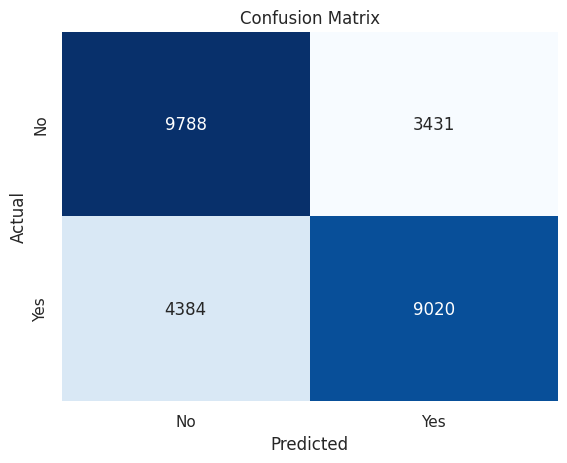

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have the true target variable 'y_test' and the predicted target variable 'y_pred'

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)

# Set labels, title, and ticks
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['No', 'Yes'])
ax.yaxis.set_ticklabels(['No', 'Yes'])

# Show the plot
plt.show()

Best Hyperparameters: {'C': 10.0, 'max_iter': 100, 'solver': 'liblinear'}
Accuracy: 0.6441422829883935
Precision: 0.64266008421664
Recall: 0.660399880632647
F1-score: 0.651409228052101


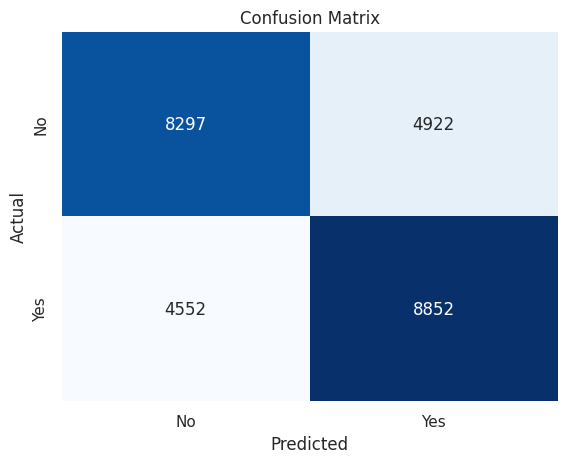

In [117]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


model = LogisticRegression()

param_grid = {
    'C': [0.1, 1.0, 10.0], 
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 500, 1000]
}

scoring = make_scorer(f1_score)

grid_search = GridSearchCV(model, param_grid, cv=5, scoring=scoring, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['No', 'Yes'])
ax.yaxis.set_ticklabels(['No', 'Yes'])
plt.show()

In [118]:
feature_names = X.columns

# Create a dataframe to store the feature importance
importance_table = pd.DataFrame({'Feature': feature_names, 'Importance': best_model.coef_[0]})

# Sort the table by importance in descending order
importance_table = importance_table.sort_values(by='Importance', ascending=False)

# Print the feature importance table
print(importance_table)

                Feature  Importance
7               artrite    0.762981
4        cardiovascular    0.678123
6                   avc    0.666878
0             tabagismo    0.580543
5   hipercolesterolemia    0.402084
2           hipertensão    0.342759
1                cancer    0.275793
3              diabetes    0.258969
8             obesidade    0.177768
11                  upf    0.044312
10         escolaridade   -0.017084
9                  sexo   -1.111193


In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

    
train_X, valid_X, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

train_X_tensor = torch.tensor(train_X.values, dtype=torch.float32)
train_y_tensor = torch.tensor(train_y.values, dtype=torch.float32)
valid_X_tensor = torch.tensor(valid_X.values, dtype=torch.float32)
valid_y_tensor = torch.tensor(valid_y.values, dtype=torch.float32)

dataset_train = TensorDataset(train_X_tensor, train_y_tensor)
dataset_valid = TensorDataset(valid_X_tensor, valid_y_tensor)

train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset_valid, batch_size=32, shuffle=False)


In [37]:
import torch
import torch.nn as nn
import torch.optim as optim

input_dim = train_X_tensor.shape[1]

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(16, 4)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(4, 2)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Define the neural network model
input_dim = train_X_tensor.shape[1]
model = NeuralNetwork(input_dim)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 40
train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    train_outputs = model(train_X_tensor)
    train_loss = loss_fn(train_outputs, train_y_tensor.long())

    # Backward pass and optimization
    train_loss.backward()
    optimizer.step()

    # Store training loss history
    train_loss_history.append(train_loss.item())

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(valid_X_tensor)
        val_loss = loss_fn(val_outputs, valid_y_tensor.long())

    # Store validation loss history
    val_loss_history.append(val_loss.item())

    # Print the loss for every epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss.item()}, Val Loss: {val_loss.item()}")

Epoch 1/40, Train Loss: 0.6948068737983704, Val Loss: 0.6940874457359314
Epoch 2/40, Train Loss: 0.6933913826942444, Val Loss: 0.6927317380905151
Epoch 3/40, Train Loss: 0.6919771432876587, Val Loss: 0.6913765072822571
Epoch 4/40, Train Loss: 0.6905637979507446, Val Loss: 0.6900238990783691
Epoch 5/40, Train Loss: 0.6891518831253052, Val Loss: 0.6886754035949707
Epoch 6/40, Train Loss: 0.6877423524856567, Val Loss: 0.6873297095298767
Epoch 7/40, Train Loss: 0.6863349080085754, Val Loss: 0.6859861612319946
Epoch 8/40, Train Loss: 0.6849284172058105, Val Loss: 0.6846445798873901
Epoch 9/40, Train Loss: 0.6835232377052307, Val Loss: 0.6833052039146423
Epoch 10/40, Train Loss: 0.6821196675300598, Val Loss: 0.6819677948951721
Epoch 11/40, Train Loss: 0.6807172894477844, Val Loss: 0.680631160736084
Epoch 12/40, Train Loss: 0.6793146729469299, Val Loss: 0.6792944669723511
Epoch 13/40, Train Loss: 0.6779112219810486, Val Loss: 0.6779587268829346
Epoch 14/40, Train Loss: 0.6765085458755493, Val

<Figure size 800x600 with 0 Axes>

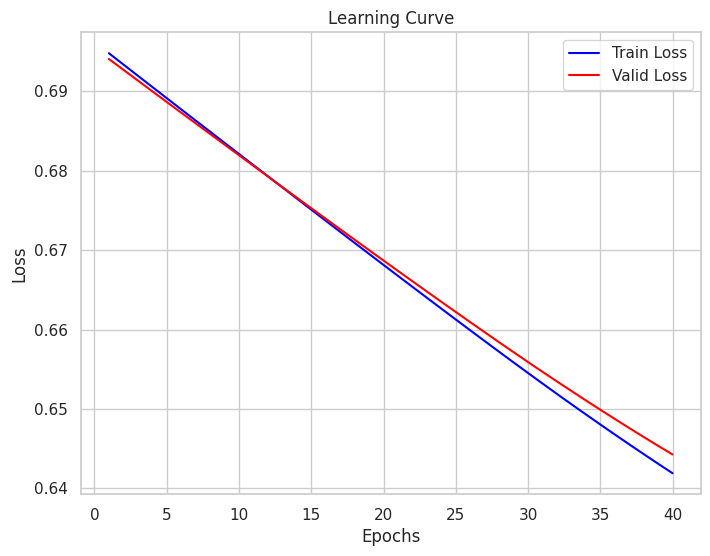

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Filter out None and NaN values from train_loss_history and train_accuracy_history
filtered_train_loss_history = [loss for loss in train_loss_history if loss is not None and not np.isnan(loss)]
filtered_valid_loss_history = [loss for loss in val_loss_history if loss is not None and not np.isnan(loss)]

# Generate the epochs for the x-axis
epochs = range(1, len(filtered_train_loss_history) + 1)

plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Train Loss', color='blue')
plt.plot(range(1, num_epochs + 1), val_loss_history, label='Valid Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [40]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
test_X_tensor = torch.tensor(X_test.values, dtype=torch.float32)
test_y_tensor = torch.tensor(y_test.values, dtype=torch.float32)
# Evaluation on test data
model.eval()
with torch.no_grad():
    test_outputs = model(test_X_tensor)
    test_predictions = torch.argmax(test_outputs, dim=1)
    test_predictions = test_predictions.detach().cpu().numpy()

# Convert tensor to numpy arrays
test_y_numpy = test_y_tensor.detach().cpu().numpy()

# Calculate accuracy
accuracy = accuracy_score(test_y_numpy, test_predictions)

# Calculate F1 score
f1 = f1_score(test_y_numpy, test_predictions)

# Calculate confusion matrix
cm = confusion_matrix(test_y_numpy, test_predictions)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(cm)

Accuracy: 0.727074877948356
F1 Score: 0.0
Confusion Matrix:
[[12361     0]
 [ 4640     0]]
